In [3]:
#Load all all of the packages we need.

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cenpy
from cenpy import products

In [4]:
sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/San_Diego_Region_SB743_VMT_Maps.shp') #Load in the Database.

## Subsetting our data. 

We are concerned about data on the Census Tract level, for the estimated year 2025, using the most recently developed SANDAG model. We also subset for residents and VMT per capita to best match SB 743. 

In [5]:
gdf = sandagvmt[(sandagvmt['geo']=='Census Tract') & (sandagvmt['vmt_year']==2025) & (sandagvmt['version']=='ABM2+ / 2021 RP')&(sandagvmt['vmt_type']=='Residents') & (sandagvmt['vmt_metric']=='Per Capita')]

## Collect Census Data

In [45]:
import requests
#get=NAME,B01001_001E,B01001H_001E,B03002_001,B03002_003,B03002_004,B03002_005,B03002_006,B03002_007,B03002_008,B03002_009,B03002_012,B25119_001
r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E&for=tract&in=state:06+county:073')
censusdata = r.json()
df=pd.DataFrame(censusdata[1:], columns=censusdata[0])
df.head()

,NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E,state,county,tract
0,"Census Tract 165.04, San Diego County, California",6856,3138,6856,601,121,442,0,58,352,2144,46440,06,073,016504
1,"Census Tract 170.51, San Diego County, California",5188,2914,5188,346,0,737,168,0,448,575,106161,06,073,017051
2,"Census Tract 170.53, San Diego County, California",3305,2552,3305,3,0,198,0,0,256,296,155208,06,073,017053
3,"Census Tract 170.54, San Diego County, California",5731,4209,5731,82,9,370,0,0,252,809,101875,06,073,017054
4,"Census Tract 170.52, San Diego County, California",5277,2629,5277,0,21,1530,23,150,267,657,103336,06,073,017052


In [48]:
df['pc_nonHispanicWhite'] = df.B01001H_001E.astype(float) / df.B01001_001E.astype(float) * 100 
ca=df[df['state']=='06']
sd=ca[ca['county']=='073']


In [49]:
sd.rename(columns={"B01001_001E":"total_pop","B01001H_001E":"white_nh","B25119_001E": "median_income", "B03002_001E": "total_race","B03002_004E":"black_nh", "B03002_005E":"native_na_alaska_nh","B03002_006E":"asian_nh","B03002_007E":"native_hi_pi_nh","B03002_008E":"other_race","B03002_009E":"mixed_race","B03002_012E": "total_hisp",}, inplace=True)

sd['pc_Black'] = sd.black_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_amindian'] = sd.native_na_alaska_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_pacislander'] = sd.native_hi_pi_nh.astype(float) / sd.total_pop.astype(float) * 100
sd['pc_asian'] = sd.asian_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_mixedrace'] = sd.mixed_race.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_hispanic'] = sd.total_hisp.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_other_race'] = sd.other_race.astype(float) / sd.total_pop.astype(float) * 100 



In [50]:
#Because we can't use cenpy,and because the SANDAG database does not have a GEOID Field, we need to laod the tracts in with geometry
censustractsGDF = sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/tl_2019_06_tract.shp') #Load in the Tracts with geometry so we can Database.

In [51]:
censustractsGDF = censustractsGDF[(censustractsGDF['COUNTYFP']=='073')]

In [93]:
sd.head()

,NAME,total_pop,white_nh,total_race,black_nh,native_na_alaska_nh,asian_nh,native_hi_pi_nh,other_race,mixed_race,...,tract,pc_nonHispanicWhite,pc_Black,pc_amindian,pc_pacislander,pc_asian,pc_mixedrace,pc_hispanic,pc_other_race,namesplit
0,"Census Tract 165.04, San Diego County, California",6856,3138,6856,601,121,442,0,58,352,...,016504,45.770128,8.766044,1.764877,0.000000,6.446908,5.134189,31.271879,0.845974,Census Tract 165.04
1,"Census Tract 170.51, San Diego County, California",5188,2914,5188,346,0,737,168,0,448,...,017051,56.168080,6.669237,0.000000,3.238242,14.205860,8.635312,11.083269,0.000000,Census Tract 170.51
2,"Census Tract 170.53, San Diego County, California",3305,2552,3305,3,0,198,0,0,256,...,017053,77.216339,0.090772,0.000000,0.000000,5.990923,7.745840,8.956127,0.000000,Census Tract 170.53
3,"Census Tract 170.54, San Diego County, California",5731,4209,5731,82,9,370,0,0,252,...,017054,73.442680,1.430815,0.157041,0.000000,6.456116,4.397138,14.116210,0.000000,Census Tract 170.54
4,"Census Tract 170.52, San Diego County, California",5277,2629,5277,0,21,1530,23,150,267,...,017052,49.819973,0.000000,0.397953,0.435854,28.993746,5.059693,12.450256,2.842524,Census Tract 170.52


In [52]:
sd['namesplit'] = sd['NAME'].str.split(',',expand=True,n=1)[0] #Split the name so we can join!

In [55]:
print(sd.shape)
print(censustractsGDF.shape)

censustractsGDF = censustractsGDF.merge(sd,left_on='NAMELSAD',right_on='namesplit') #Join the Census Data to the Tract Ge information.

(628, 24)
(628, 13)


In [136]:
censustractsGDF = censustractsGDF.to_crs('EPSG:2230')
censustractsGDF.geometry =censustractsGDF.representative_point() #set the tract geometry to the centroids
joinDf=gpd.sjoin(gdf,censustractsGDF,how='left',predicate='intersects') #create the spatial join #Spatial Join the SANDAG and Census Data!

In [92]:
join.columns

Index(['OBJECTID', 'version', 'vmt_year', 'year_txt', 'scenario_i', 'geo',
       'geo_id', 'name', 'vmt_type', 'vmt_metric', 'persons', 'vmt',
       'vmt_per_ca', 'pctmean', 'pctmeantxt', 'map_legend', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'NAME_y', 'total_pop', 'white_nh',
       'total_race', 'black_nh', 'native_na_alaska_nh', 'asian_nh',
       'native_hi_pi_nh', 'other_race', 'mixed_race', 'total_hisp',
       'median_income', 'state', 'county', 'tract', 'pc_nonHispanicWhite',
       'pc_Black', 'pc_amindian', 'pc_pacislander', 'pc_asian', 'pc_mixedrace',
       'pc_hispanic', 'pc_other_race', 'namesplit'],
      dtype='object')

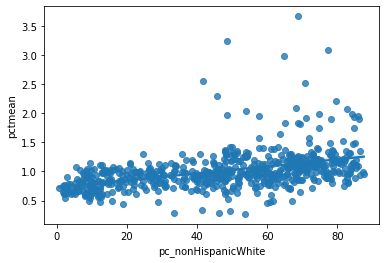

In [99]:
import seaborn as sns
ax = sns.regplot(x="pc_nonHispanicWhite", y="pctmean", data=joinDf) #Not a huge relation





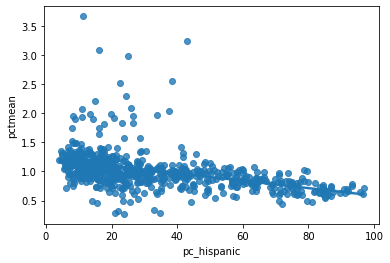

In [98]:
ax = sns.regplot(x="pc_hispanic", y="pctmean", data=joinDf) #Not a huge relation


[Text(0, 0, '85% to 100% of Regional Mean'),
 Text(1, 0, '50% to 85% of Regional Mean'),
 Text(2, 0, '100% to 125% of Regional Mean'),
 Text(3, 0, 'Less than 50% of Regional Mean'),
 Text(4, 0, 'Not Enough Data'),
 Text(5, 0, 'More than 125% of Regional Mean'),
 Text(6, 0, 'No Data')]

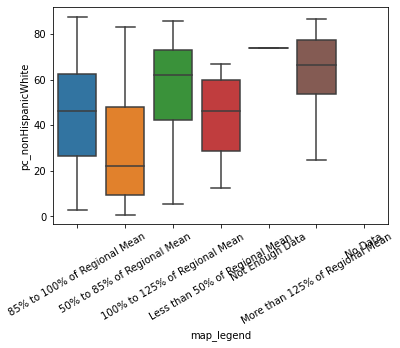

In [106]:
#join.boxplot(by='map_legend',column=['pc_nonHispanicWhite'],grid= False)  #Very Basic Boxplot - Looking at Percent white by categories of data!

ax = sns.boxplot(x='map_legend',y='pc_nonHispanicWhite',data=joinDf)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


## K - Means Cluster Analysis


In [143]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

joinDf.dropna(inplace=True)

cols_to_plot = ['vmt','total_pop','median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic']

scaler = preprocessing.StandardScaler().fit(joinDf[cols_to_plot])
df_scaled = pd.DataFrame(scaler.transform(joinDf[cols_to_plot]), 
                         columns=cols_to_plot, index=joinDf.index)
df_scaled.dropna(inplace=True)


kmeans = KMeans(n_clusters=8, random_state=1).fit(df_scaled)


joinDf['cluster_id'] = kmeans.labels_

joinDf.head()

,level_0,index,OBJECTID,version,vmt_year,year_txt,scenario_i,geo,geo_id,name,...,pc_nonHispanicWhite,pc_Black,pc_amindian,pc_pacislander,pc_asian,pc_mixedrace,pc_hispanic,pc_other_race,namesplit,cluster_id
0,0,3341,3342,ABM2+ / 2021 RP,2025.0,2025,462.0,Census Tract,100.0,1,...,77.238927,0.000000,0.000000,0.000000,3.621080,3.330100,15.809893,0.00000,Census Tract 1,0
1,1,3342,3343,ABM2+ / 2021 RP,2025.0,2025,462.0,Census Tract,201.0,2.01,...,82.971973,0.528821,0.581703,0.000000,3.966155,4.547858,7.403490,0.00000,Census Tract 2.01,0
2,2,3343,3344,ABM2+ / 2021 RP,2025.0,2025,462.0,Census Tract,202.0,2.02,...,74.636724,0.088067,0.000000,0.066050,8.344342,3.302510,13.562307,0.00000,Census Tract 2.02,0
3,3,3344,3345,ABM2+ / 2021 RP,2025.0,2025,462.0,Census Tract,300.0,3,...,72.914678,5.077305,0.000000,0.133613,2.786791,2.462302,16.625310,0.00000,Census Tract 3,0
4,4,3345,3346,ABM2+ / 2021 RP,2025.0,2025,462.0,Census Tract,400.0,4,...,56.511444,5.998421,0.000000,0.000000,11.312812,2.446725,23.257038,0.47356,Census Tract 4,7


[]

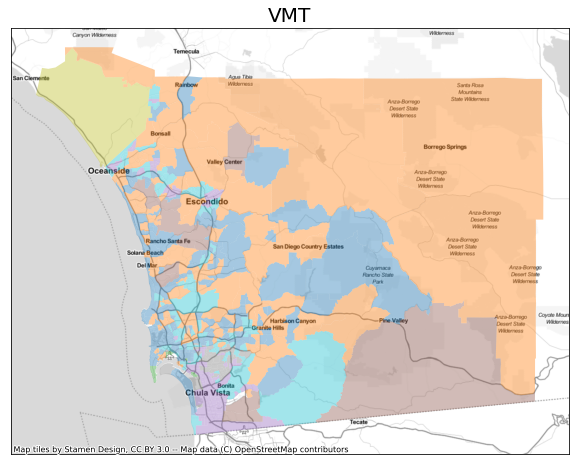

In [144]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))
joinDf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, legend=False, 
                                   ax=ax, alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('VMT', fontsize=20)                           
#ax.set_ylim([3.98e6, 4.14e6])
ax.set_xticks([])
ax.set_yticks([])